In [1]:
__author__ = 'Shi Fan, Federica Bianco'
import glob
import pandas as pd, numpy as np
import pylab as pl
import os
%pylab inline
from scipy import signal
from scipy.optimize import leastsq
import pickle as pkl

Populating the interactive namespace from numpy and matplotlib


In [2]:
int_times = [1, 3, 7, 20, 55, 125]

# setting values for image dimension early on
nrow = 240
ncol = 320
nband = 3

REREAD=False
#REREAD=True
#FBB adding env variable so it is easy to run on different machines
datapath=os.getenv('UIdata')
print (datapath)
if not datapath:
    datapath = '/scratch/share/dm3805'
    print (datapath)

if REREAD:
    
    close_photos = {}
    mid_photos = {}

    for i in int_times:
        close_path = datapath+'/SNRtest/*%dint*close*.raw' % i
        mid_path = datapath+'/SNRtest/*%dint*mid*.raw' % i
        
        close_photos[i] = glob.glob(close_path)
        mid_photos[i] = glob.glob(mid_path)
        
    #Converting series into Numpy arrays
    close_photo_arr = {}
    mid_photo_arr = {}

    for key, value in close_photos.iteritems():
        close_photo_arr[key] = np.array(value)[np.argsort(value)] 
        
    for key, value in mid_photos.iteritems():
        mid_photo_arr[key] = np.array(value)[np.argsort(value)]
        
    pl.figure()
    pl.imshow(np.fromfile(close_photo_arr[7][10], dtype=np.uint8).reshape(nrow, ncol, nband)[75:175,100:200]);

None
/scratch/share/dm3805


In [3]:
pickle_path = '/scratch/share/fbianco/ht_pickles'
#pickle_path = 'ht_pickles'

if REREAD:
    close_photo_resized = {}
    mid_photo_resized = {}
    
    # initialization
    for key, value in close_photo_arr.iteritems():
        close_photo_resized[key] = np.zeros(len(value))
    for key, value in mid_photo_arr.iteritems():
        mid_photo_resized[key] = np.zeros(len(value))

    # close range
    for r in close_photo_resized:
        for i,f in enumerate(close_photo_arr[r]):
            close_photo_resized[r][i] = sum(np.fromfile(f,dtype=np.uint8).reshape(nrow,ncol,nband)[75:175,100:200]) 
    pkl.dump(close_photo_resized, open(pickle_path+'/SNRtest_close.pkl', 'wb'))
    
    # mid range
    for r in mid_photo_resized:
        for i,f in enumerate(mid_photo_arr[r]):
            mid_photo_resized[r][i] = sum(np.fromfile(f,dtype=np.uint8).reshape(nrow,ncol,nband)[75:175,100:200]) 
    pkl.dump(mid_photo_resized, open(pickle_path+'/SNRtest_mid.pkl', 'wb'))

else:
    #FBB this is when we do not want to reread the images but just use the time series
    pklfiles = glob.glob(datapath+'/ht_pickles/SNRtest*.pkl')
    close_photo_resized = pkl.load(open(pickle_path+'/SNRtest_close.pkl', 'rb'))
    mid_photo_resized = pkl.load(open(pickle_path+'/SNRtest_mid.pkl', 'rb'))

In [4]:
#function definitions
#we like them altogether so we can easily find a function definition when we need to

def mynorm(flux):
    flux -= flux.mean()
    return 2*(flux-flux.min())/(flux.max()-flux.min())

# flux is a dictionary that has shutter frequency as the key and corresponding flux array as the value
# runtime is a dictionary that has camera frequency as the key and corresponding time index as the value
# close is a boolean that stands for whether it is close-up flux or mid-range flux
def plot_flux_by_runtime(flux, c_freq, runtime, close):
    for key, value in flux.iteritems():
        pl.figure(figsize=(20,5))
        if close:
            color = 'dodgerblue'
            pl.title('Close-up Flux: Shutter 119.75Hz; Camera '+str(c_freq)+'Hz; Integration '+str(key)+'ms', fontsize=20)
        else:
            color = 'steelblue'
            pl.title('Mid-range Flux: Shutter 119.75Hz; Camera '+str(c_freq)+'Hz; Integration '+str(key)+'ms', fontsize=20)
        try:
            pl.plot(runtime[c_freq], flux[key], '-', color=color, linewidth=0.75)
            pl.plot(runtime[c_freq], flux[key], 'o', color=color)
        except:
            print ('Camera frequency has to be 4')
#           in this particular test, it has to be 4, but really it depends on our data
#           we need to check if the value is valid
            break
        pl.xlim(0,125)
        
        pl.xlabel("Seconds", fontsize=15)
        pl.ylabel("Almost normalized flux", fontsize=15)
        pl.ylim(-.1,2.1)
        pl.show() 

# the simulated sine wave gets shifted up by the value of its magnitude
# so that all of its values are non-negative
def sine_wave(time, freq, mag=1, phase=0):
    wave = mag*np.sin(2*np.pi*freq*time+phase)+mag
    return wave

# we are folding the runtime into 2 shutter cycles in this case
# if we want to be more general, we can feed the number of shutter cycles in as an input
def folding(flux, runtime, freq):
    runtime_mod = np.mod(runtime, 2.0/freq)
    return flux, runtime_mod # return time in microseconds

def camera_meets_shutter_wave(time, cam, s_freq):
    #simplified for this particular case
    if time.shape!=cam.shape:
        print ('Time series must have the same length as camera wave')
    
    return sine_wave(time, float(s_freq))*cam

## Setting up data

In [5]:
#Creating dictionaries for flux
#Normalizing flux by (flux-mean)/std

close_flux = {}
mid_flux = {}

for key, value in close_photo_resized.iteritems():
    close_flux[key] = mynorm(value)
    
for key, value in mid_photo_resized.iteritems():
    mid_flux[key] = mynorm(value)
    
runtime4 = np.linspace(0, len(mid_photo_resized[1])/4.0, len(mid_photo_resized[1]), endpoint=True)

## Flux vs time

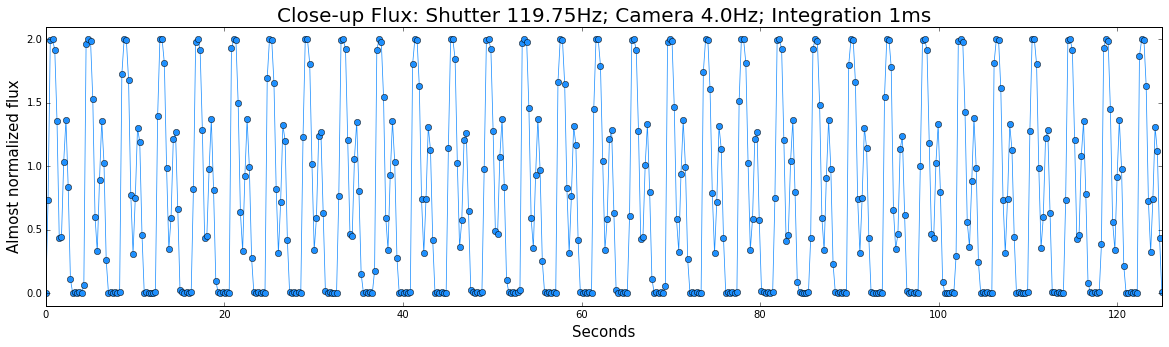

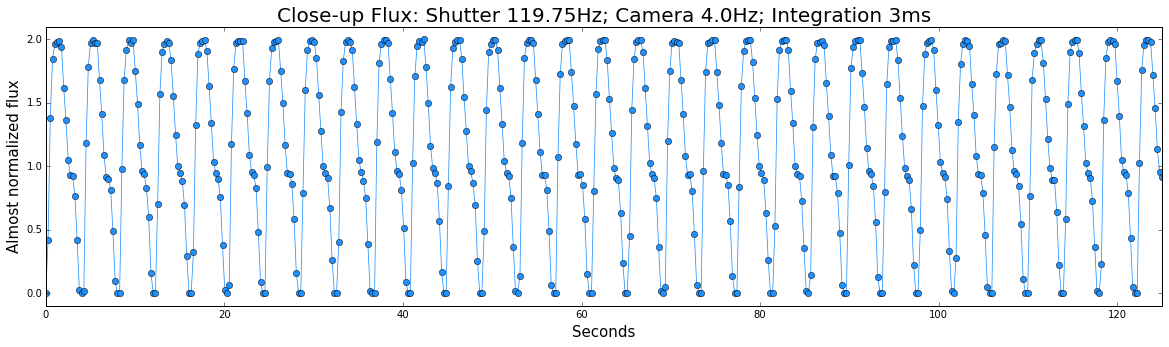

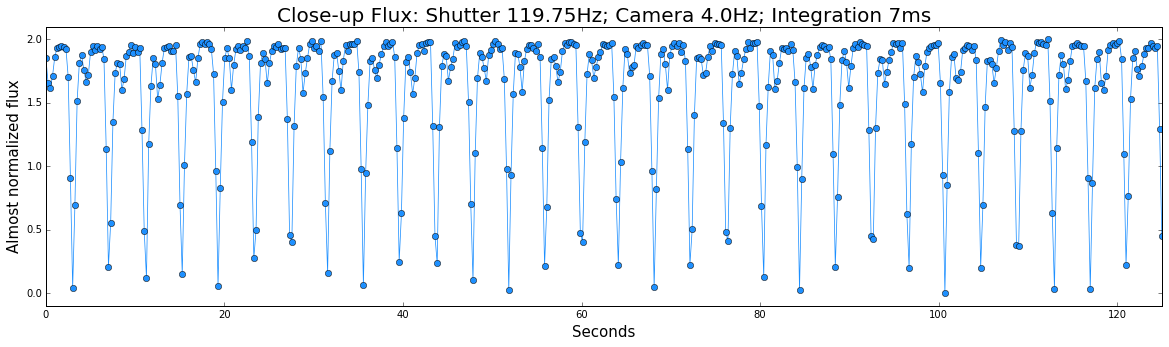

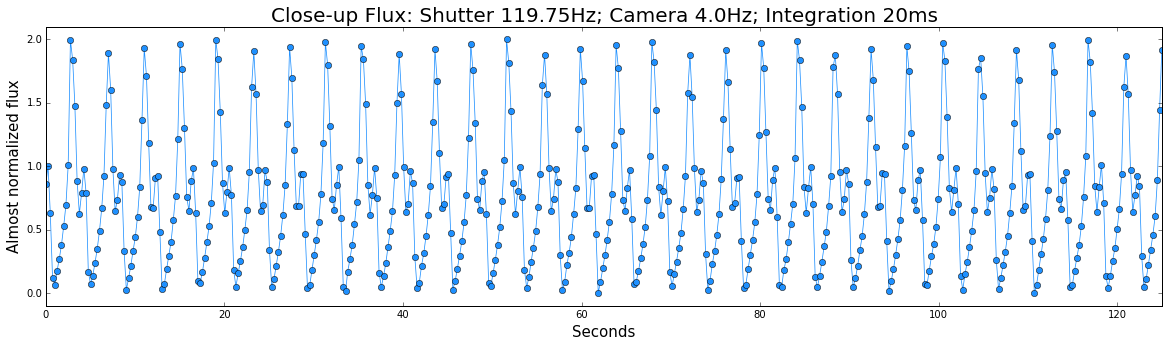

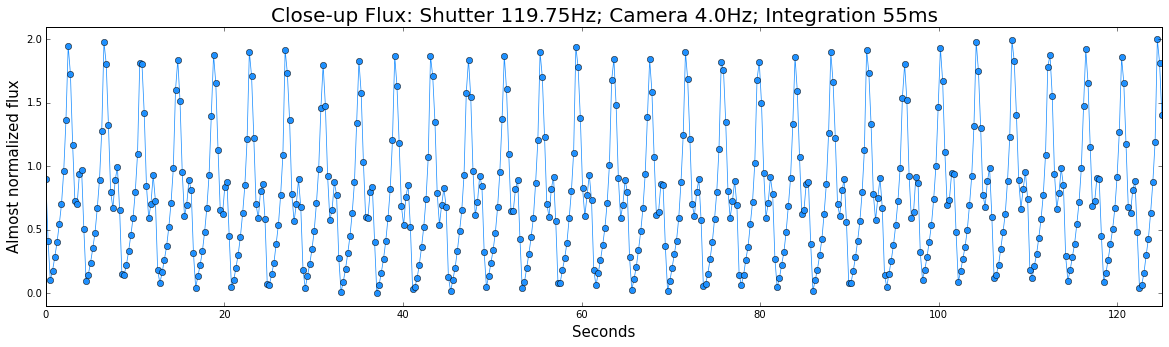

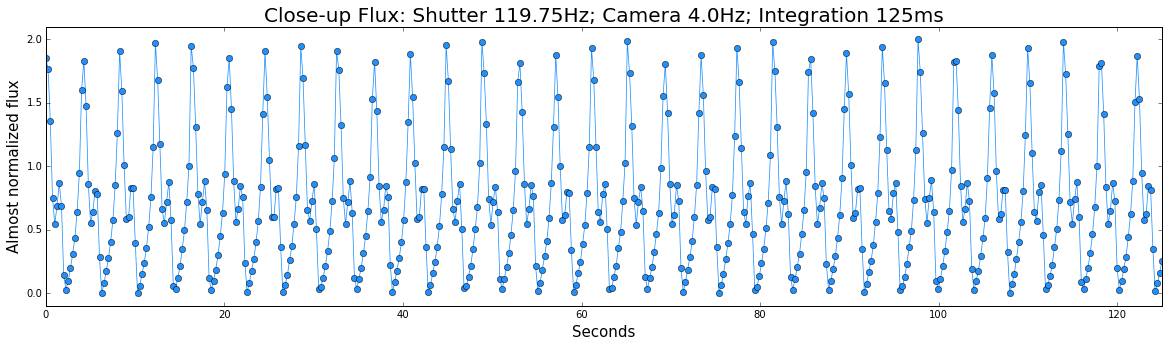

In [6]:
plot_flux_by_runtime(close_flux, 4.0, {4.0:runtime4}, True)

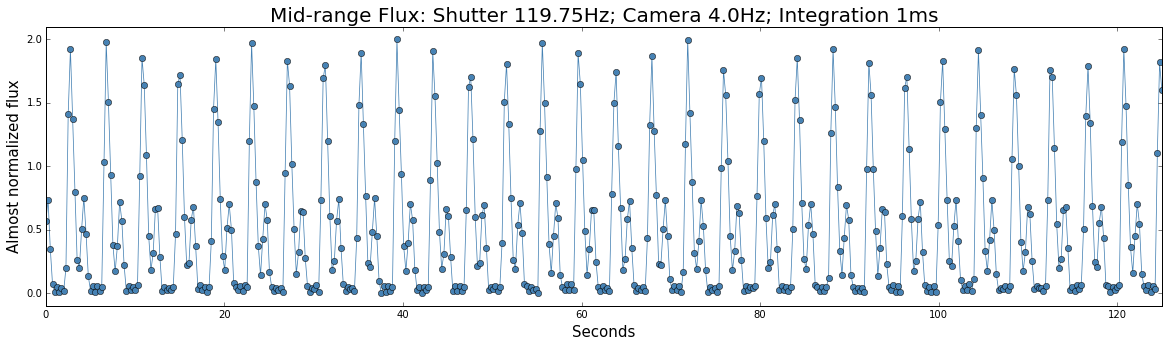

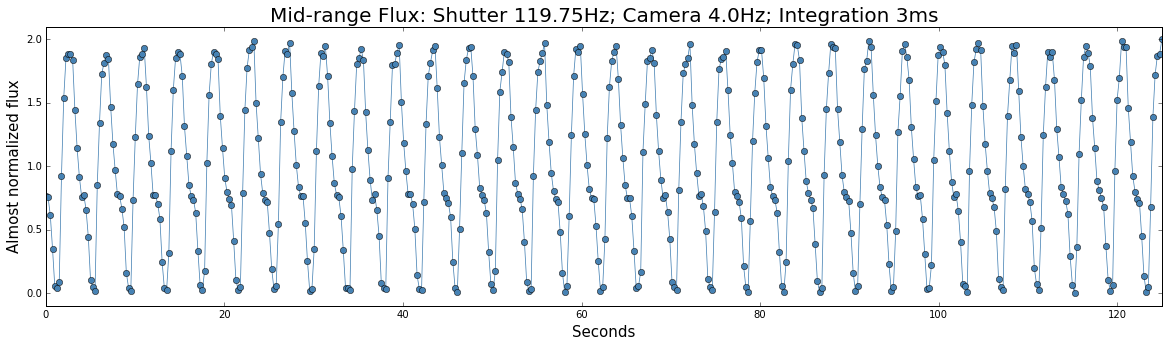

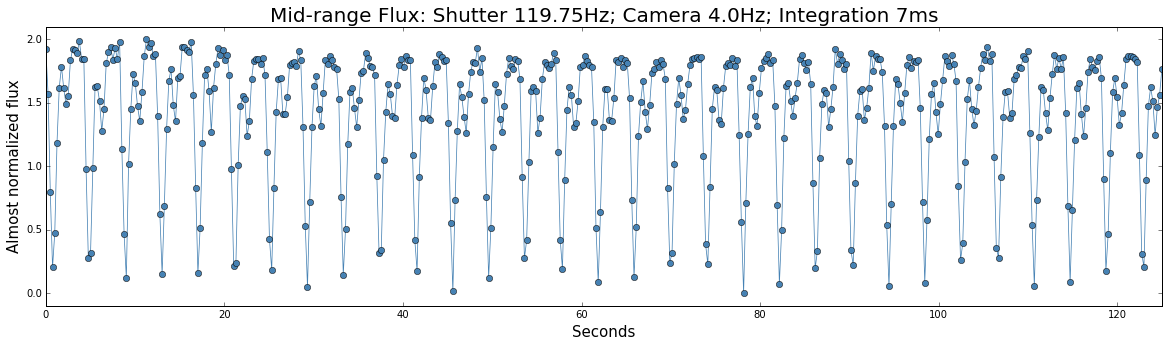

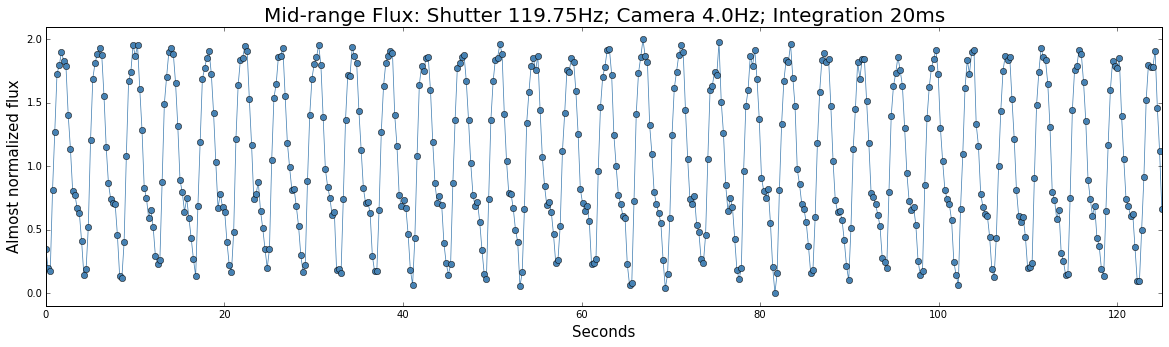

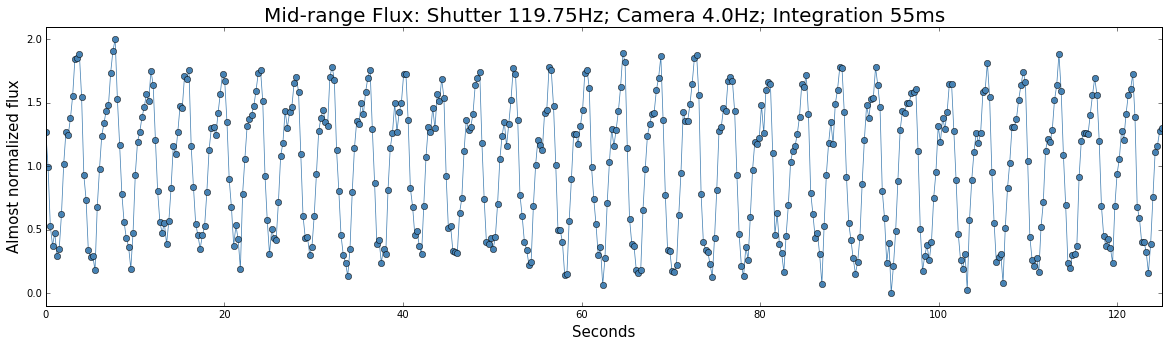

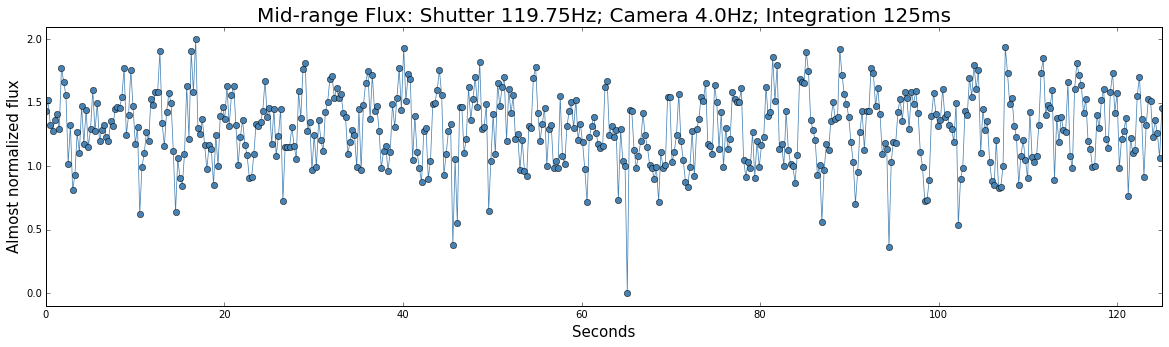

In [7]:
plot_flux_by_runtime(mid_flux, 4.0, {4.0:runtime4}, False)

## Folded flux (2 shutter cycles)

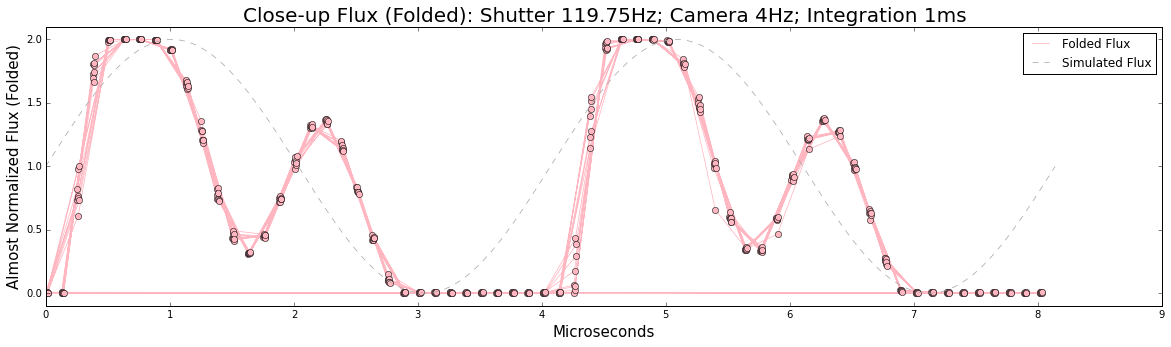

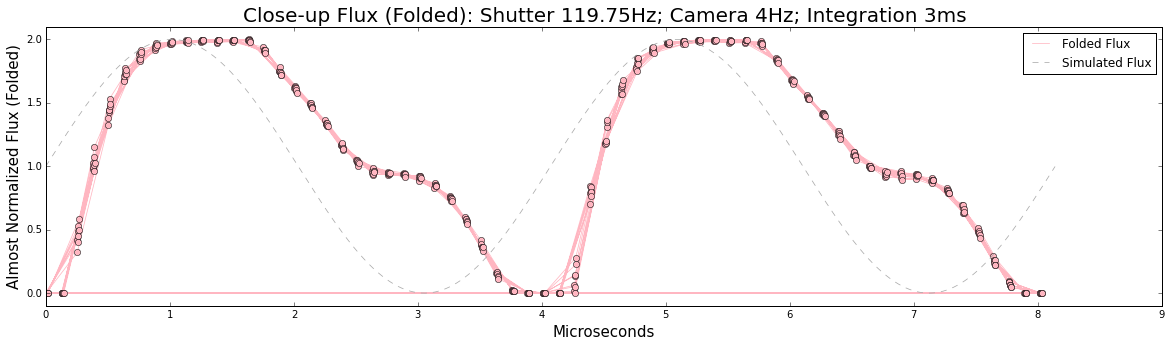

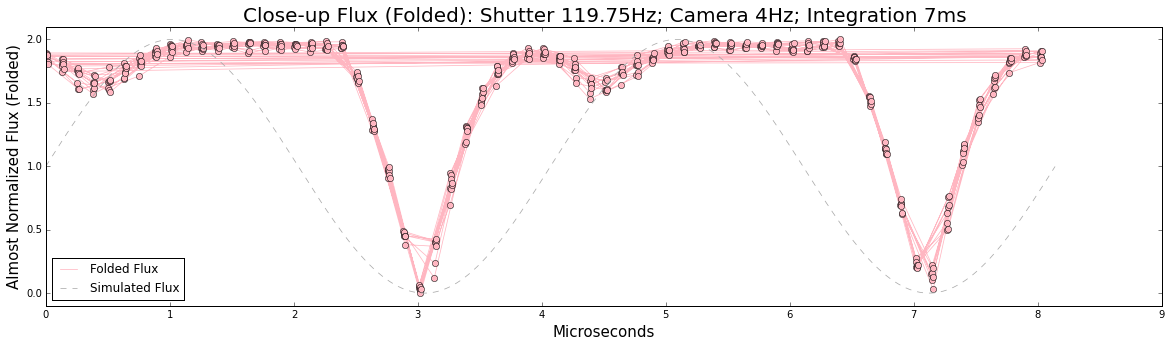

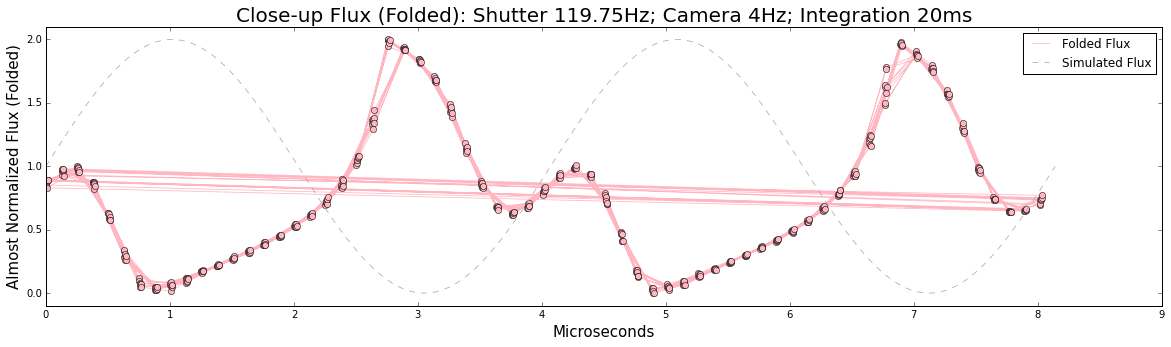

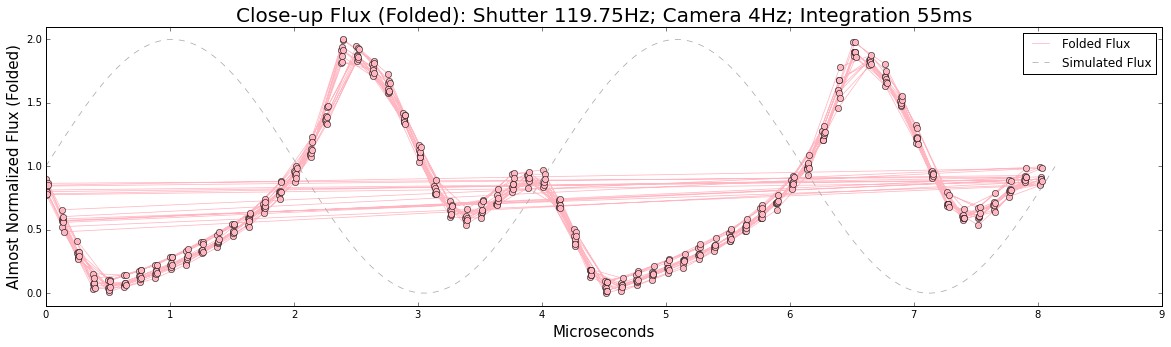

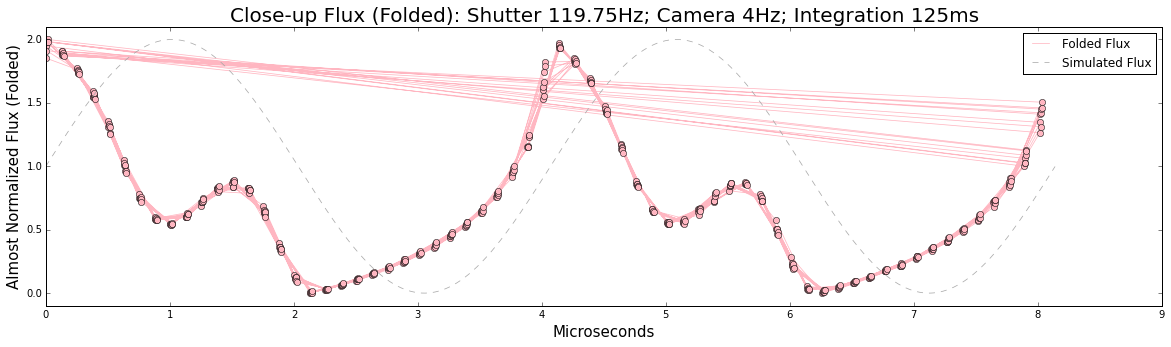

In [8]:
folded_close = {}
freq = 0.2457
time = np.linspace(0, 150, 150*1000, endpoint=False)
sine  = sine_wave(time, freq)
nsteps = 2*int(1000/freq)

for key, value in close_flux.iteritems():
    folded_close[key] = {}
    folded_close[key]['flux'], folded_close[key]['time'] = folding(value, runtime4, freq)
    
    pl.figure(figsize=(20,5))
    pl.plot(folded_close[key]['time'], folded_close[key]['flux'], '-', c='lightpink', lw=0.75, label='Folded Flux')
    pl.plot(folded_close[key]['time'], folded_close[key]['flux'], 'o', c='lightpink')
    pl.plot(time[:nsteps], sine[:nsteps], '--', color='darkgrey', linewidth = 0.75, label='Simulated Flux')
    pl.legend(loc='best')
    pl.xlabel("Microseconds", fontsize=15)
    pl.ylabel("Almost Normalized Flux (Folded)", fontsize=15)
    pl.title('Close-up Flux (Folded): Shutter 119.75Hz; Camera 4Hz; Integration '+str(key)+'ms', fontsize=20)
    pl.ylim(-.1,2.1)
    pl.show()

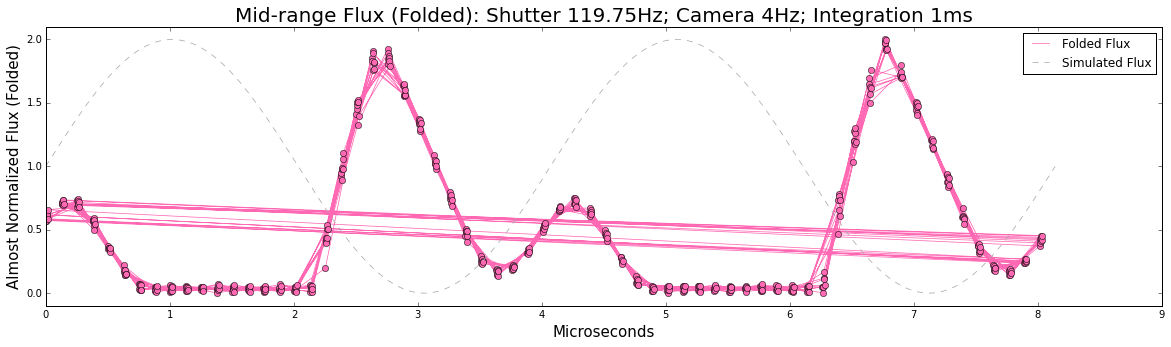

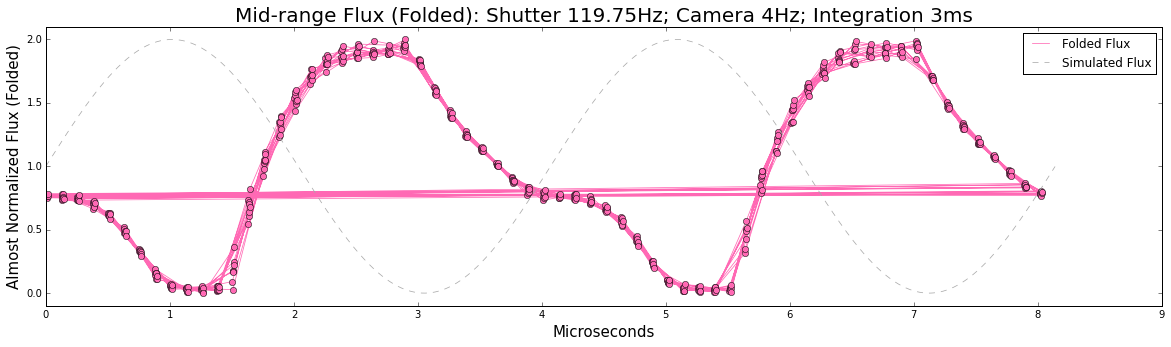

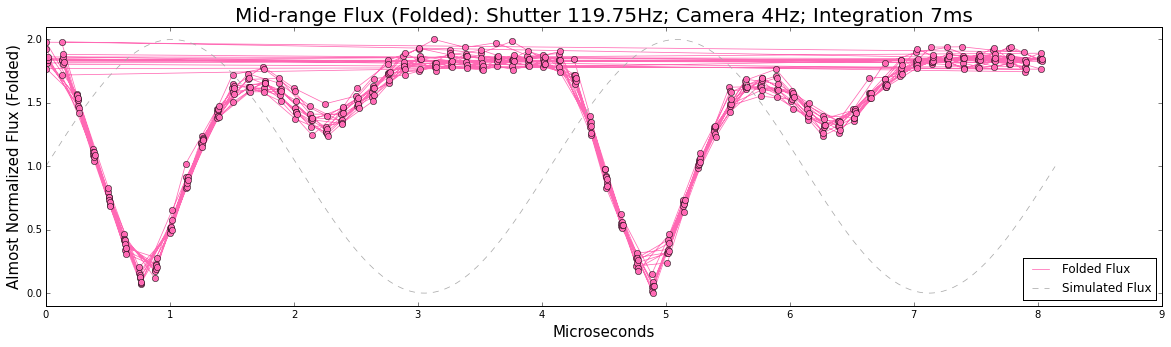

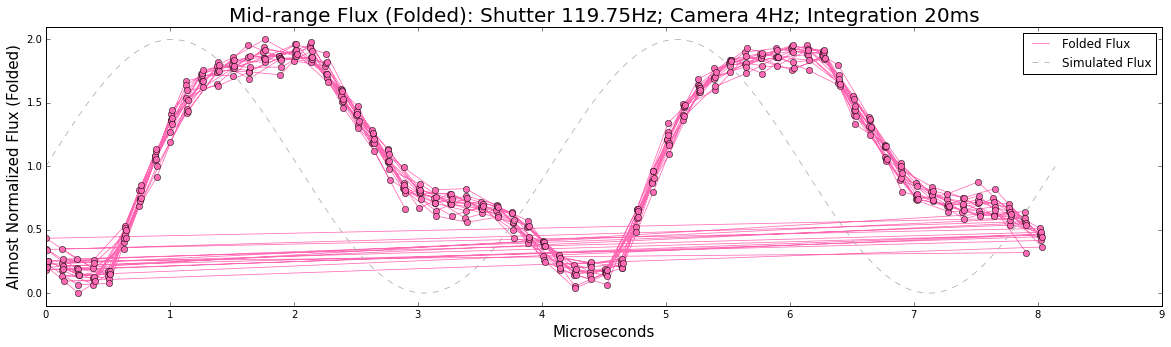

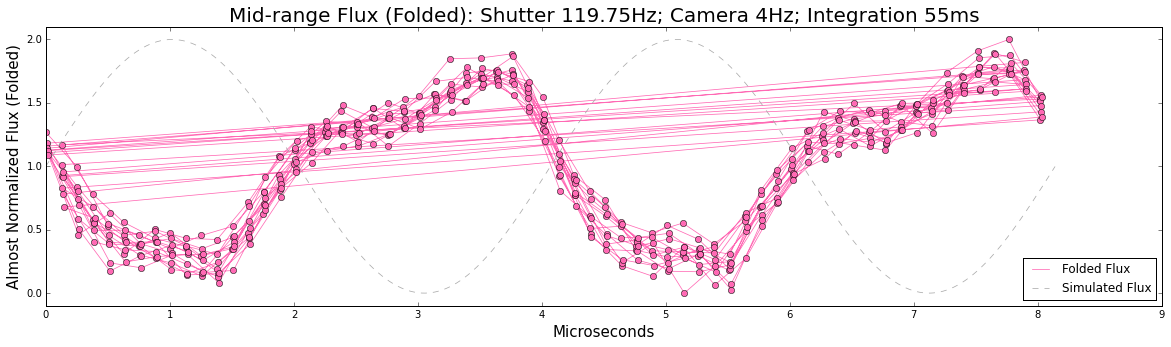

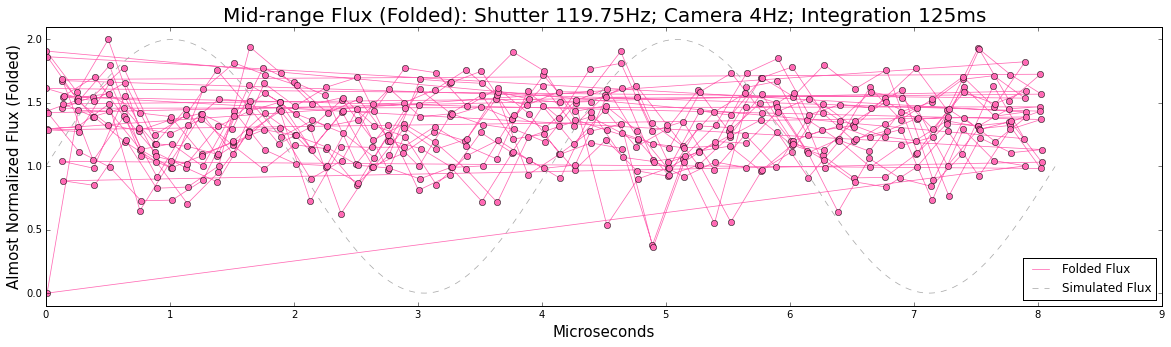

In [9]:
folded_mid = {}
freq = 0.2457
for key, value in mid_flux.iteritems():
    folded_mid[key] = {}
    folded_mid[key]['flux'], folded_mid[key]['time'] = folding(value, runtime4, freq)
    
    pl.figure(figsize=(20,5))
    pl.plot(folded_mid[key]['time'], folded_mid[key]['flux'], '-', c='hotpink', lw=0.75, label='Folded Flux')
    pl.plot(folded_mid[key]['time'], folded_mid[key]['flux'], 'o', color='hotpink')
    pl.plot(time[:nsteps], sine[:nsteps], '--', color='darkgrey', linewidth = 0.75, label='Simulated Flux')
    pl.legend(loc='best')
    pl.xlabel("Microseconds", fontsize=15)
    pl.ylabel("Almost Normalized Flux (Folded)", fontsize=15)
    pl.title('Mid-range Flux (Folded): Shutter 119.75Hz; Camera 4Hz; Integration '+str(key)+'ms', fontsize=20)
    pl.ylim(-.1,2.1)
    pl.show()

## Testing for best-fitting phase

#### Visualizing the error between simulated wave and actual flux

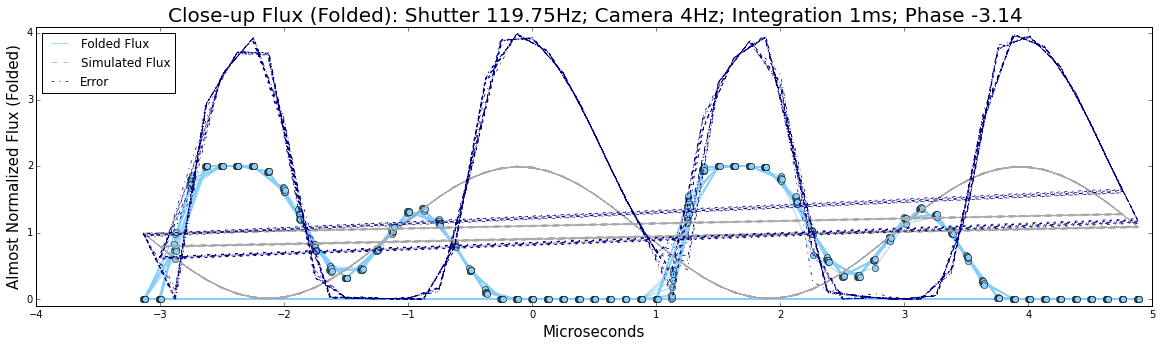

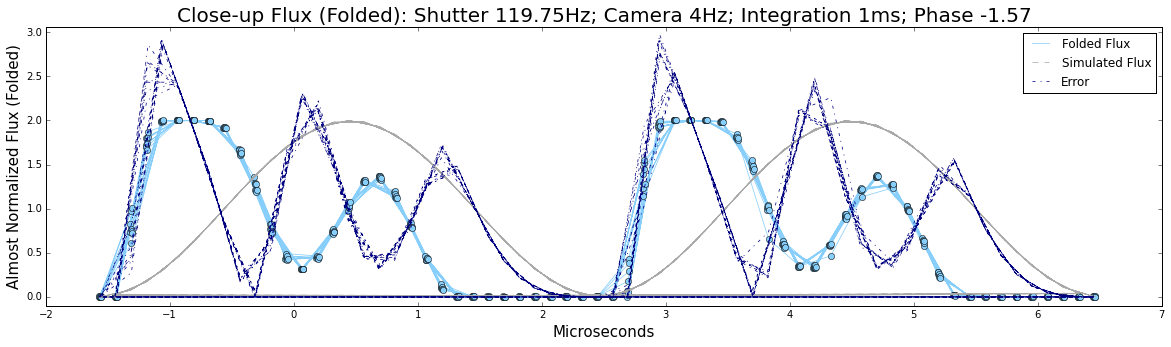

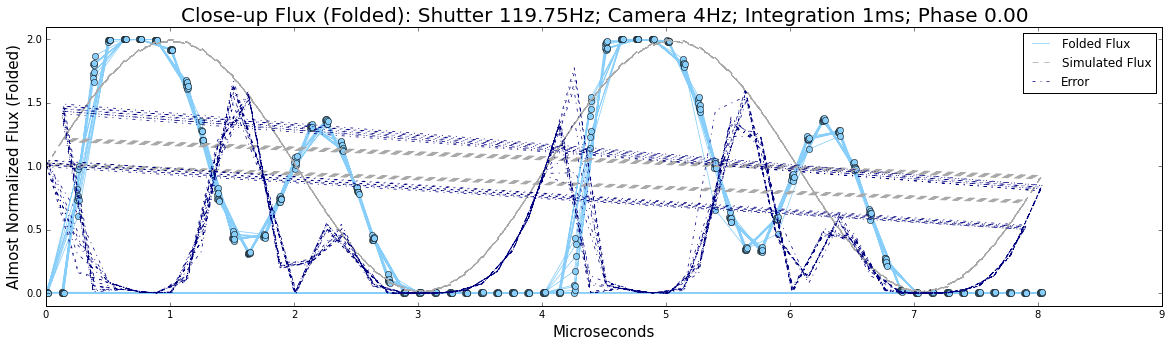

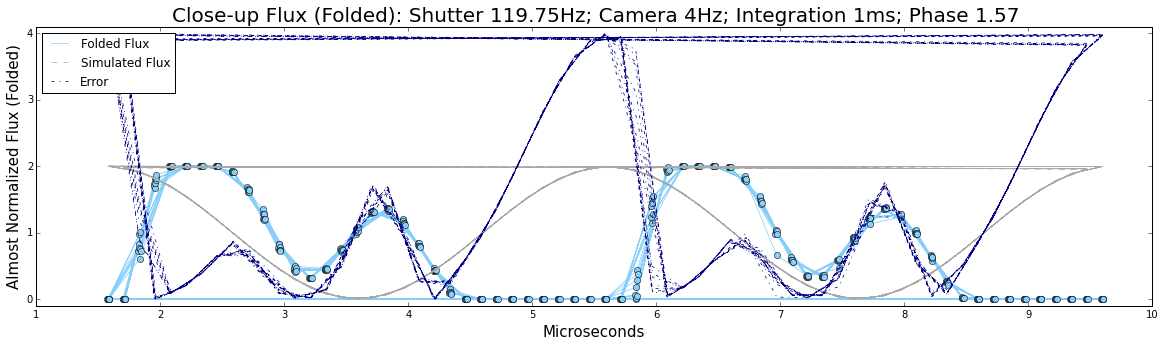

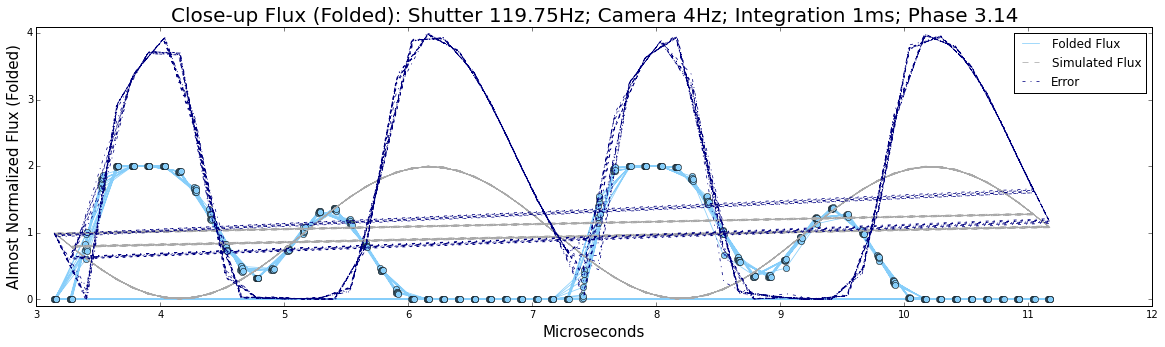

In [10]:
for phase in np.arange(-np.pi, np.pi+.01, np.pi/2):
    time_arr = folded_close[1]['time']+phase
    sine_arr = sine_wave(folded_close[1]['time'], 0.2475, mag=1, phase=phase)
    pl.figure(figsize=(20,5))
    pl.plot(time_arr, folded_close[1]['flux'], '-', c='lightskyblue', lw=0.75, label='Folded Flux')
    pl.plot(time_arr, folded_close[1]['flux'], 'o', c='lightskyblue')
    pl.plot(time_arr, sine_arr, '--', color='darkgrey', linewidth = 0.75, label='Simulated Flux')
    pl.plot(time_arr, (sine_arr-folded_close[1]['flux'])**2, '-.', c='navy', lw=0.75, label='Error')
    pl.legend(loc='best')
    pl.xlabel("Microseconds", fontsize=15)
    pl.ylabel("Almost Normalized Flux (Folded)", fontsize=15)
    pl.title('Close-up Flux (Folded): Shutter 119.75Hz; Camera 4Hz; Integration 1ms; Phase %.2f'%phase, fontsize=20)
    temp_max = np.max(np.array([np.max(folded_close[1]['flux']), np.max(sine_arr), np.max((sine_arr-folded_close[1]['flux'])**2)]))
    pl.ylim(-.1,temp_max+.1)
    pl.show()

#### For all integration times, loop over 10 phases within range (-pi, +pi, pi/5), get the squared errors for all phases, and store them in two dictionaries

In [11]:
rss_close = {}
phases = np.arange(-np.pi, np.pi+.01, np.pi/5)
for key, value in folded_close.iteritems():
    rss_close[key] = []
    for phase in phases:
        time_arr = value['time']+phase
        sine_arr = sine_wave(value['time'], 0.2475, mag=1, phase=phase)
        rss_close[key].append(np.sum((value['flux']-sine_arr)**2))
        
rss_mid = {}
for key, value in folded_mid.iteritems():
    rss_mid[key] = []
    for phase in phases:
        time_arr = value['time']+phase
        sine_arr = sine_wave(value['time'], 0.2475, mag=1, phase=phase)
        rss_mid[key].append(np.sum((value['flux']-sine_arr)**2))

#### Visualizing the squared errors over each phase for all integration times

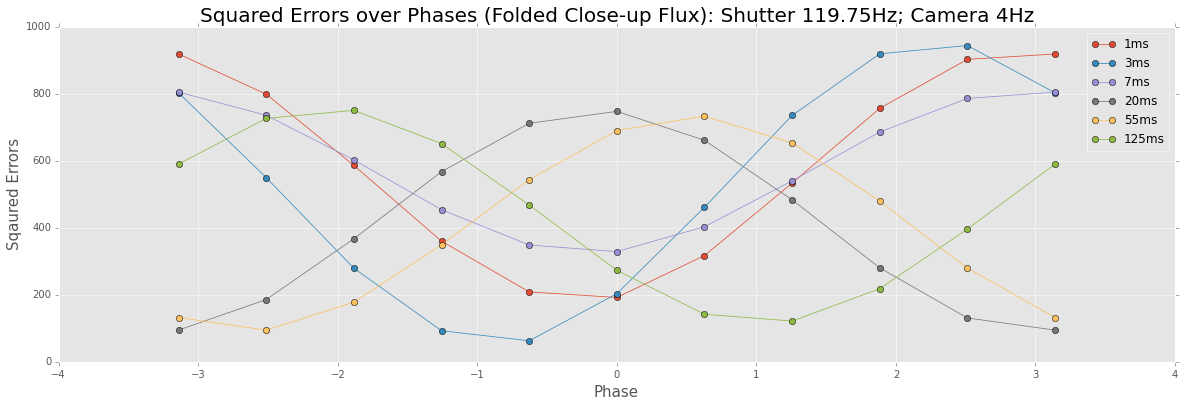

In [12]:
pl.figure(figsize=(20,6))
pl.style.use('ggplot')
for key, value in rss_close.iteritems():
    pl.plot(phases, np.array(value), '-o', lw=0.75, label='%dms'%key)
    pl.legend(loc='best')
    pl.xlabel("Phase", fontsize=15)
    pl.ylabel("Sqaured Errors", fontsize=15)
    pl.title('Squared Errors over Phases (Folded Close-up Flux): Shutter 119.75Hz; Camera 4Hz', fontsize=20)
pl.show()

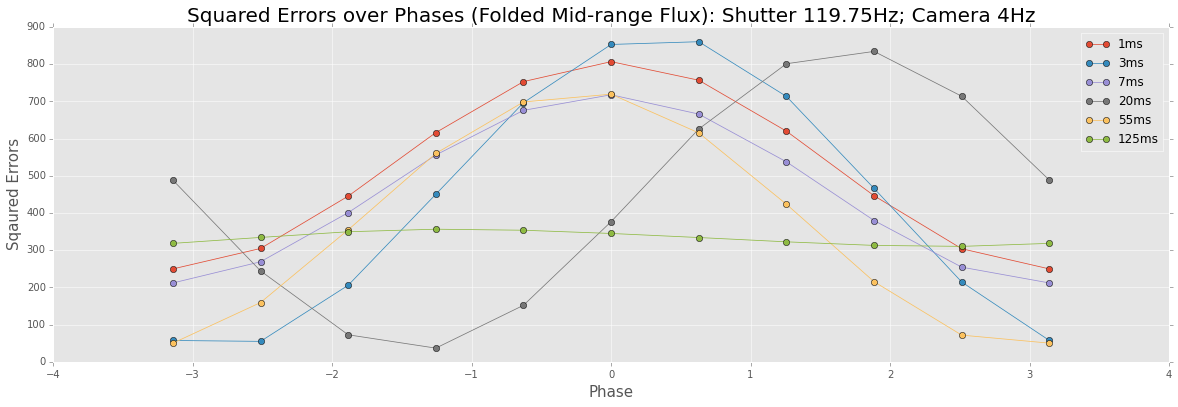

In [13]:
pl.figure(figsize=(20,6))
for key, value in rss_mid.iteritems():
    pl.plot(phases, np.array(value), '-o', lw=0.75, label='%dms'%key)
    pl.legend(loc='best')
    pl.xlabel("Phase", fontsize=15)
    pl.ylabel("Sqaured Errors", fontsize=15)
    pl.title('Squared Errors over Phases (Folded Mid-range Flux): Shutter 119.75Hz; Camera 4Hz', fontsize=20)
pl.show()

## Finding the best-fitted phase for each integration time

In [14]:
# get the index for each roughly best-fitted phase identified
phase_idx_close = []
for key, value in rss_close.iteritems():
    phase_idx_close.append(np.argmin(np.array(value)))

phase_idx_mid = []
for key, value in rss_mid.iteritems():
    phase_idx_mid.append(np.argmin(np.array(value)))

In [15]:
def minimizer(phase, data, time, freq, mag):
    return sum((data-sine_wave(time, freq, mag, phase))**2)

In [16]:
optimal_phases = {'close':[], 'mid':[]}

cnt=0
for key, value in folded_close.iteritems():
    phase = phases[phase_idx_close[cnt]]
    flux = value['flux']; time = value['time']
    result = leastsq(minimizer, phase, args=(flux, time, 0.2475, 1))
    optimal_phases['close'].append(result[0][0])
    cnt+=1
    
cnt=0
for key, value in folded_mid.iteritems():
    phase = phases[phase_idx_mid[cnt]]
    flux = value['flux']; time = value['time']
    result = leastsq(minimizer, phase, args=(flux, time, 0.2475, 1))
    optimal_phases['mid'].append(result[0][0])
    cnt+=1

### Let's sum up the squared errors to confirm if our optimal phases are actually optimal

In [17]:
cnt=0
for key, value in folded_close.iteritems():
    # get phase
    pre_mini_opt_phase = phases[phase_idx_close[cnt]]
    post_mini_opt_phase = optimal_phases['close'][cnt]
    # get simulated sine wave
    pre_mini_sine_arr = sine_wave(value['time'], 0.2475, mag=1, phase=pre_mini_opt_phase)
    post_mini_sine_arr = sine_wave(value['time'], 0.2475, mag=1, phase=post_mini_opt_phase)
    # get rss
    print 'For close-up flux with %dms int. time, is our phase returned by scipy function better than the previous estimate?'%(key)
    print np.sum((value['flux']-pre_mini_sine_arr)**2)>np.sum((value['flux']-post_mini_sine_arr)**2)
    print
    cnt+=1

For close-up flux with 1ms int. time, is our phase returned by scipy function better than the previous estimate?
True

For close-up flux with 3ms int. time, is our phase returned by scipy function better than the previous estimate?
True

For close-up flux with 7ms int. time, is our phase returned by scipy function better than the previous estimate?
True

For close-up flux with 20ms int. time, is our phase returned by scipy function better than the previous estimate?
True

For close-up flux with 55ms int. time, is our phase returned by scipy function better than the previous estimate?
True

For close-up flux with 125ms int. time, is our phase returned by scipy function better than the previous estimate?
True



### Our result makes sense. Let's plot them out.

#### Close-up

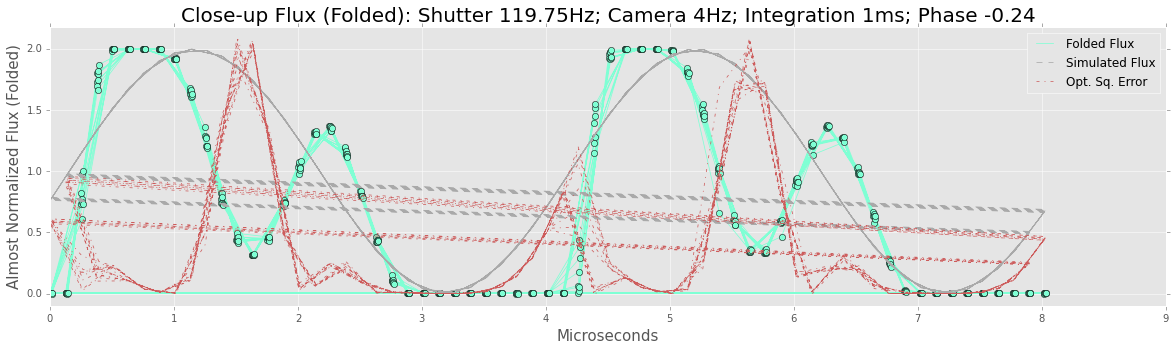

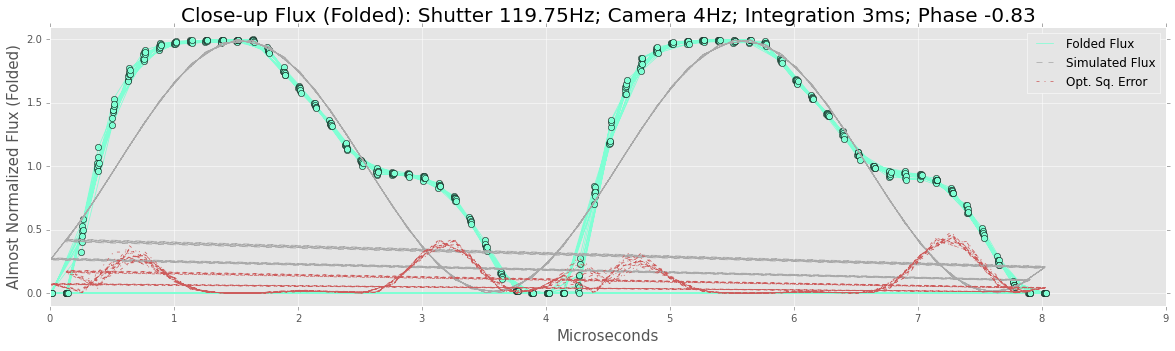

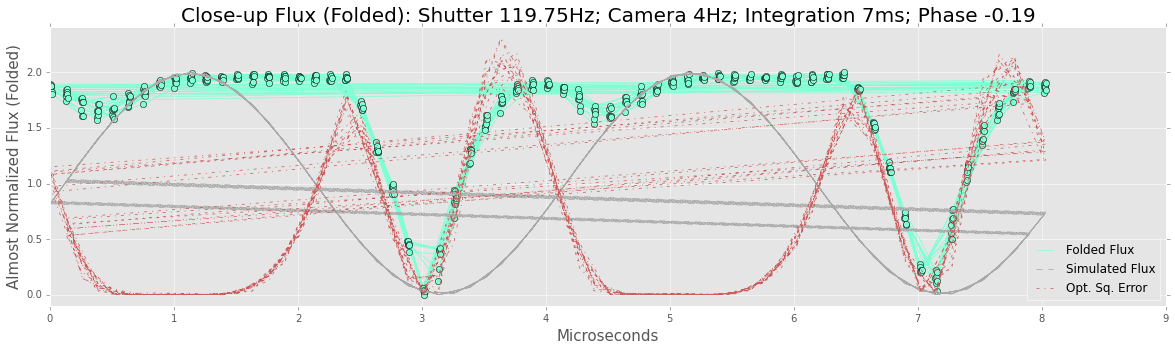

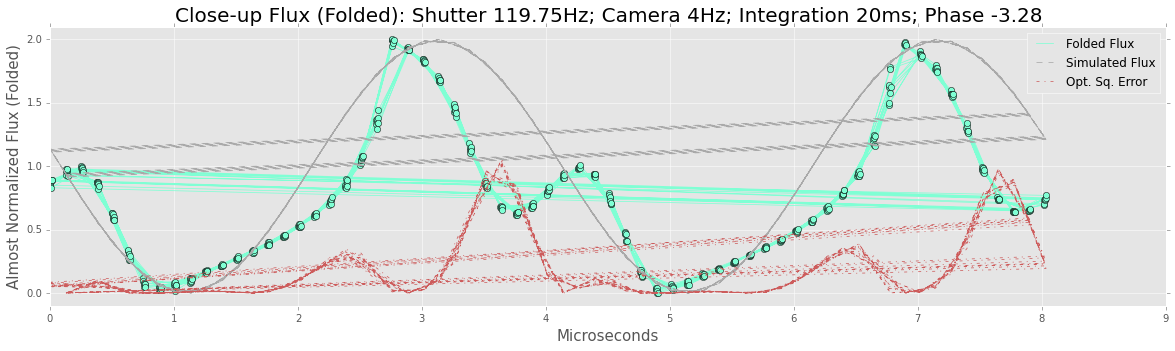

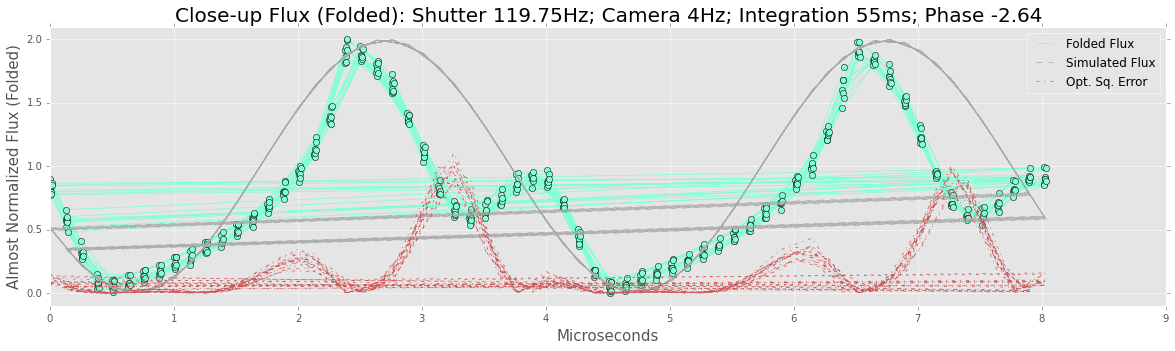

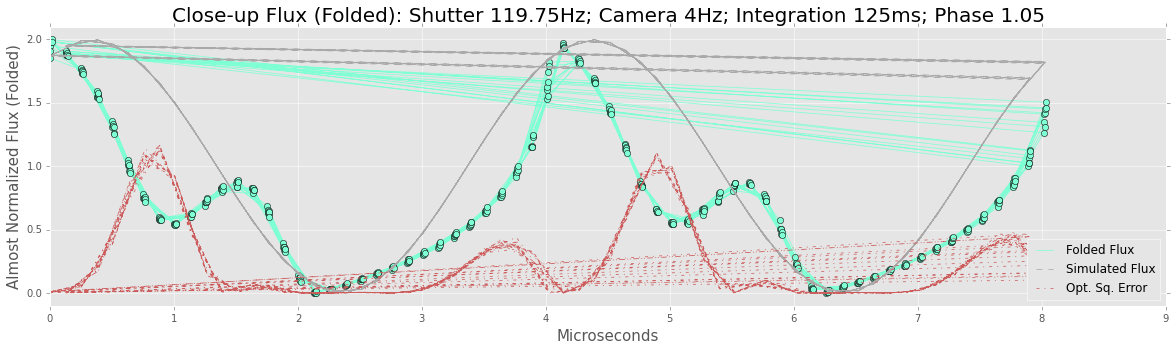

In [18]:
cnt = 0
for key, value in folded_close.iteritems():
    phase = optimal_phases['close'][cnt]
    sine_arr = sine_wave(value['time'], 0.2475, mag=1, phase=phase)
    pl.figure(figsize=(20,5))
    pl.plot(value['time'], value['flux'], '-', c='aquamarine', lw=0.75, label='Folded Flux')
    pl.plot(value['time'], value['flux'], 'o', c='aquamarine')
    pl.plot(value['time'], sine_arr, '--', color='darkgrey', lw = 0.75, label='Simulated Flux')
    pl.plot(value['time'], (sine_arr-value['flux'])**2, '-.', c='indianred', lw=0.75, label='Opt. Sq. Error')
    pl.legend(loc='best')
    pl.xlabel("Microseconds", fontsize=15)
    pl.ylabel("Almost Normalized Flux (Folded)", fontsize=15)
    pl.title('Close-up Flux (Folded): Shutter 119.75Hz; Camera 4Hz; Integration %dms; Phase %.2f'%(key,phase), fontsize=20)
    temp_max = np.max(np.array([np.max(value['flux']), np.max(sine_arr), np.max((sine_arr-value['flux'])**2)]))
    pl.ylim(-.1,temp_max+.1)
    pl.show()
    cnt+=1

#### Mid-range

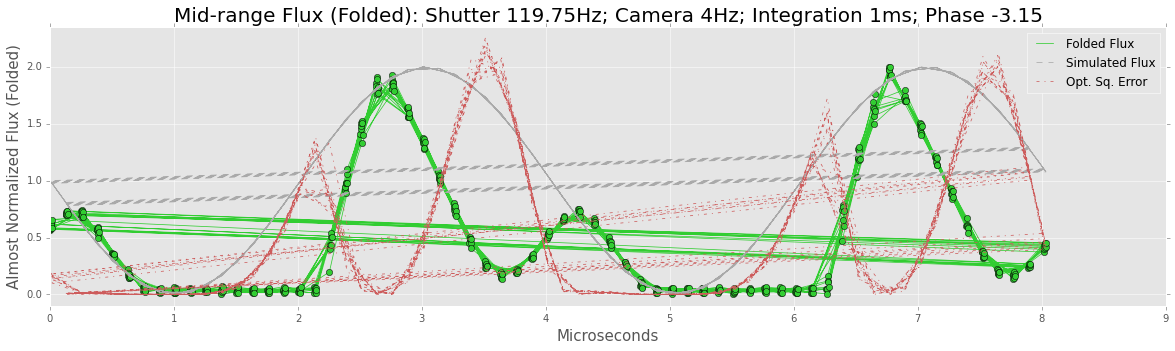

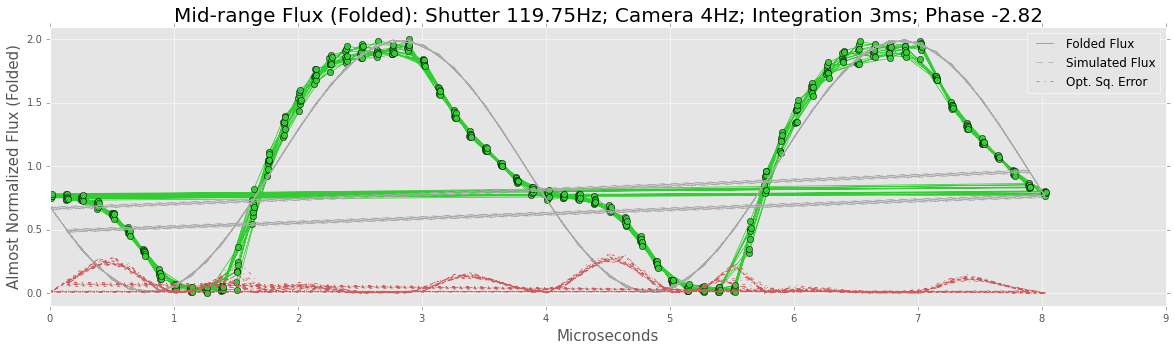

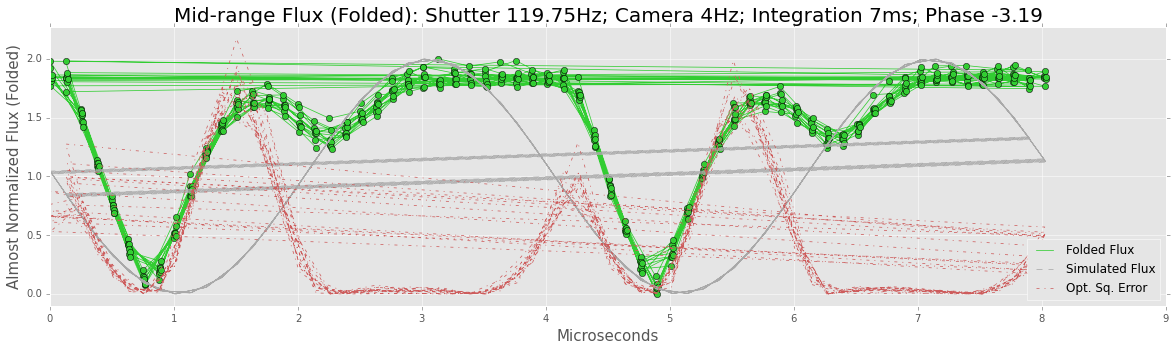

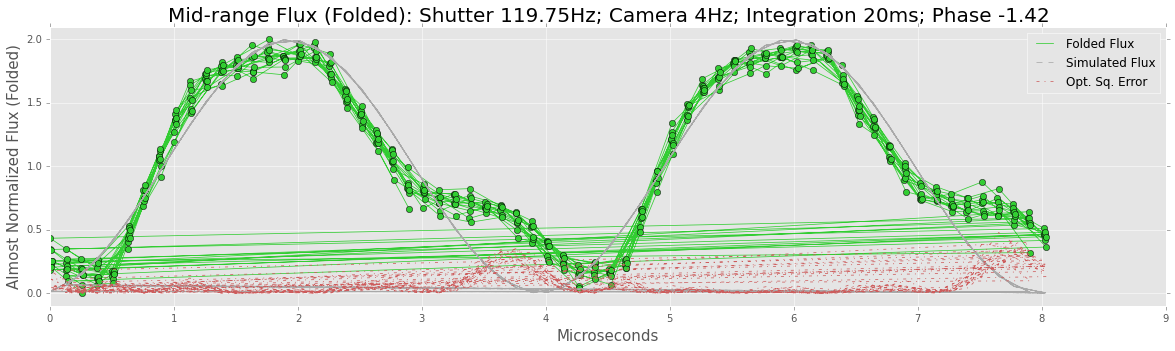

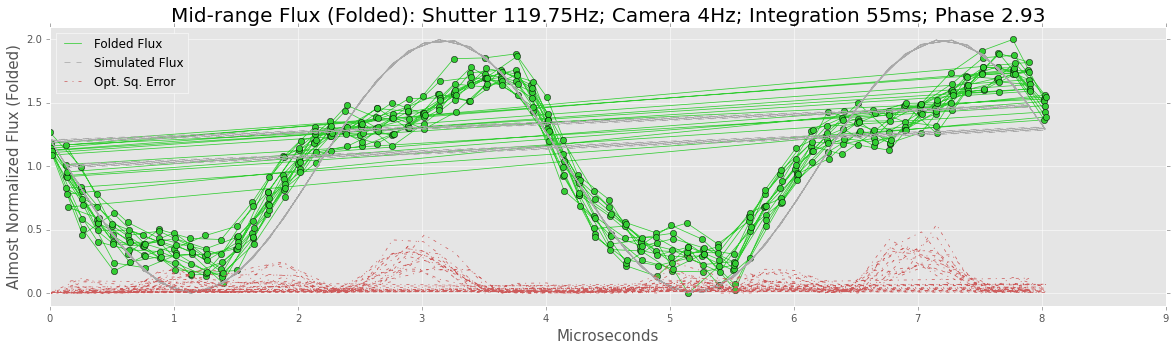

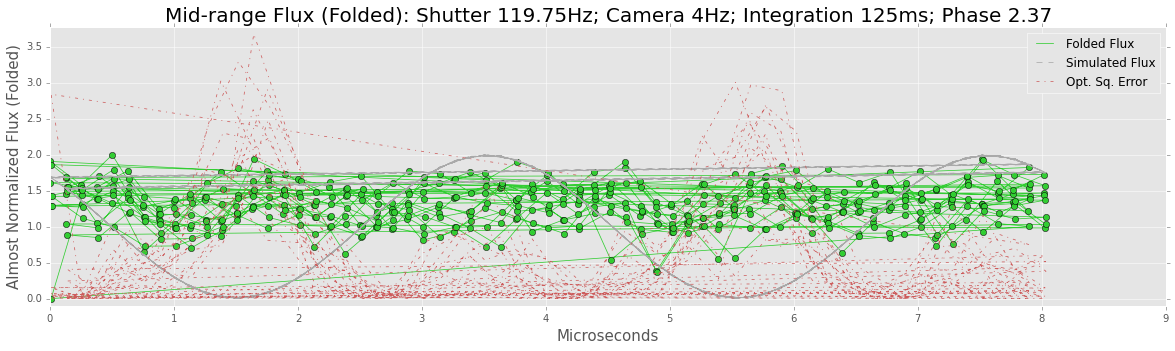

In [19]:
cnt = 0
for key, value in folded_mid.iteritems():
    phase = optimal_phases['mid'][cnt]
    sine_arr = sine_wave(value['time'], 0.2475, mag=1, phase=phase)
    pl.figure(figsize=(20,5))
    pl.plot(value['time'], value['flux'], '-', c='limegreen', lw=0.75, label='Folded Flux')
    pl.plot(value['time'], value['flux'], 'o', c='limegreen')
    pl.plot(value['time'], sine_arr, '--', color='darkgrey', lw = 0.75, label='Simulated Flux')
    pl.plot(value['time'], (sine_arr-value['flux'])**2, '-.', c='indianred', lw=0.75, label='Opt. Sq. Error')
    pl.legend(loc='best')
    pl.xlabel("Microseconds", fontsize=15)
    pl.ylabel("Almost Normalized Flux (Folded)", fontsize=15)
    pl.title('Mid-range Flux (Folded): Shutter 119.75Hz; Camera 4Hz; Integration %dms; Phase %.2f'%(key,phase), fontsize=20)
    temp_max = np.max(np.array([np.max(value['flux']), np.max(sine_arr), np.max((sine_arr-value['flux'])**2)]))
    pl.ylim(-.1,temp_max+.1)
    pl.show()
    cnt+=1

## Residuals after folding

In [20]:
# Setup for sine wave
cam4 = np.zeros(150000)
cam4[np.arange(150000)%250 == 0] = 1

time = np.arange(0, 150, .001)

inter_sn = camera_meets_shutter_wave(time, cam4, 119.75)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 150000 but corresponding boolean dimension is 125000


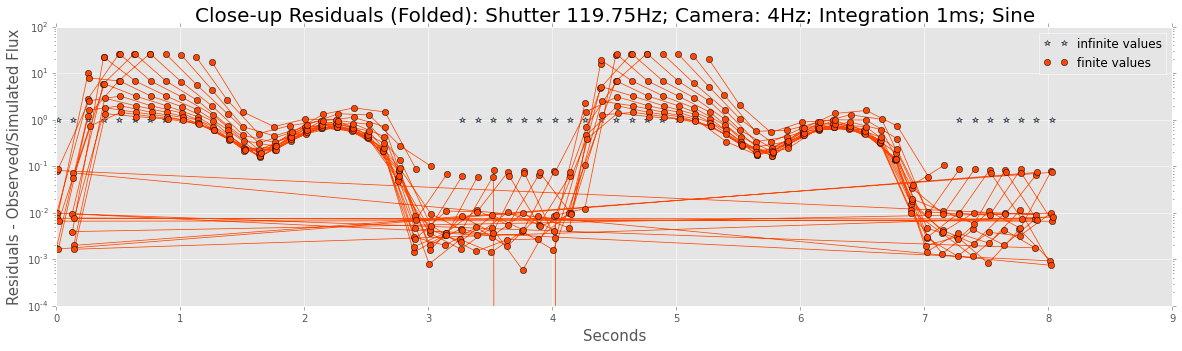

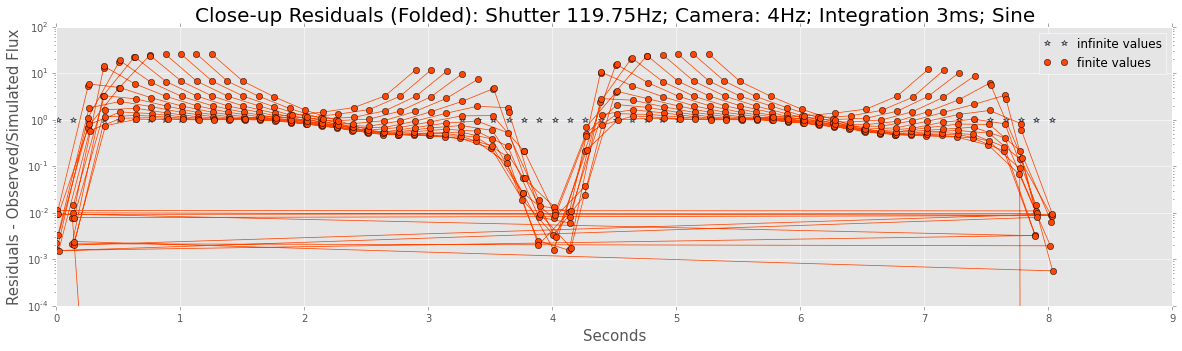

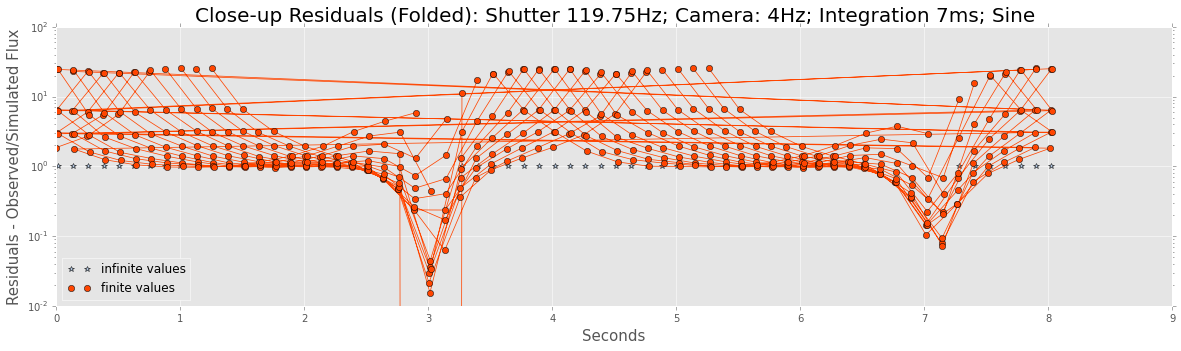

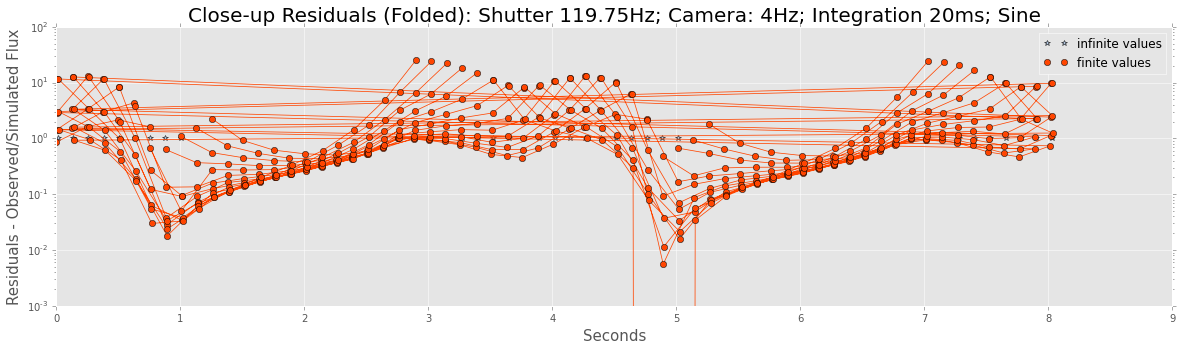

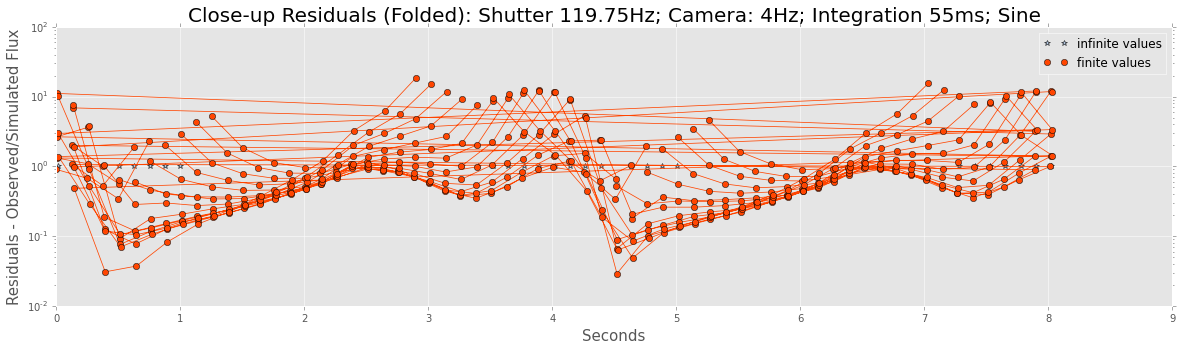

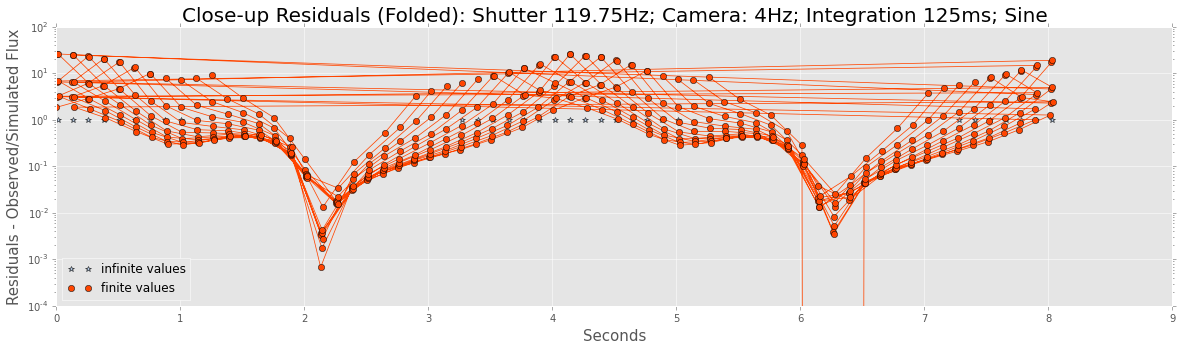

In [21]:
folded_close_res = {}

for key, value in folded_close.iteritems():
    # to be consistent with the 500 points on the flux wave
    # sample the points on the sine wave over each 250ms interval
    folded_close_res[key] = value['flux']/inter_sn[np.arange(125000)%250==0]
    
    pl.figure(figsize=(20,5))
    
    inf_idx = np.where(folded_close_res[key]==inf)[0]
    pl.plot(value['time'][inf_idx], np.ones(len(inf_idx)), '*', c='lightsteelblue', label='infinite values')
    
    pl.plot(value['time'], folded_close_res[key], '-', c='orangered', lw=0.75)
    pl.plot(value['time'], folded_close_res[key], 'o', c='orangered', label='finite values')
    pl.xlabel("Seconds", fontsize=15)
    pl.ylabel("Residuals - Observed/Simulated Flux", fontsize=15)
    pl.title('Close-up Residuals (Folded): Shutter 119.75Hz; Camera: 4Hz; Integration '+str(key)+'ms; Sine', fontsize=20)
    if inf_idx.size:
        pl.legend(loc='best')
    pl.yscale('log')
    pl.show()

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 150000 but corresponding boolean dimension is 125000


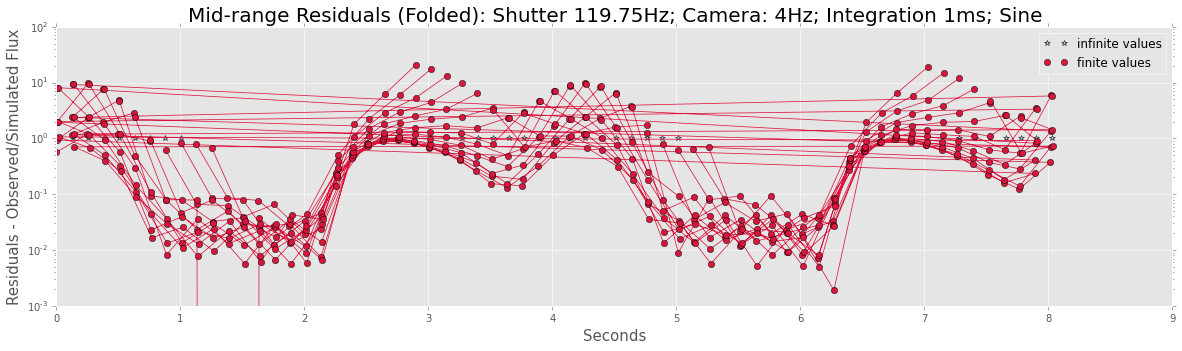

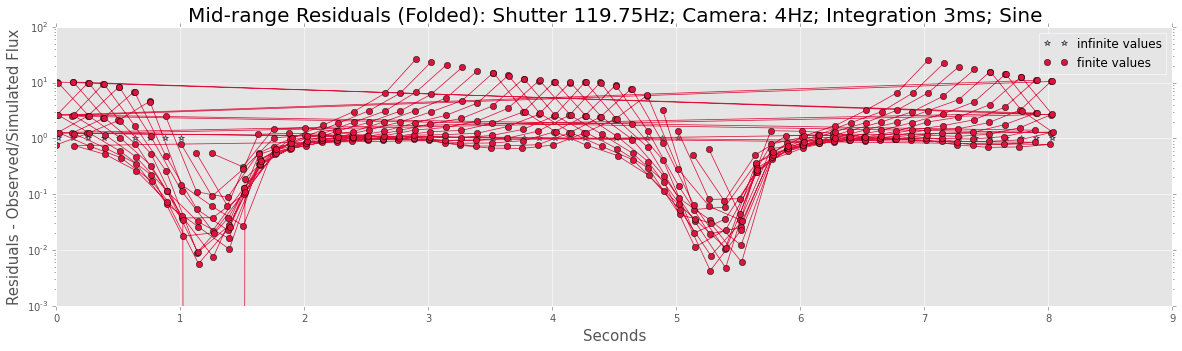

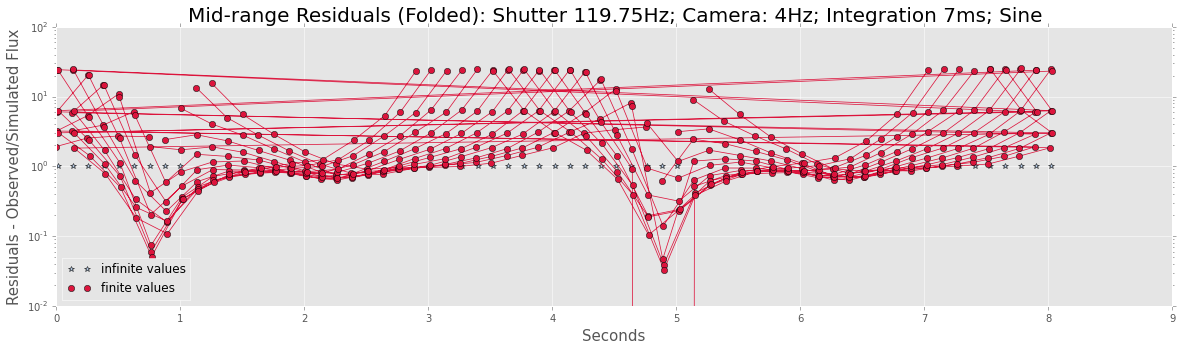

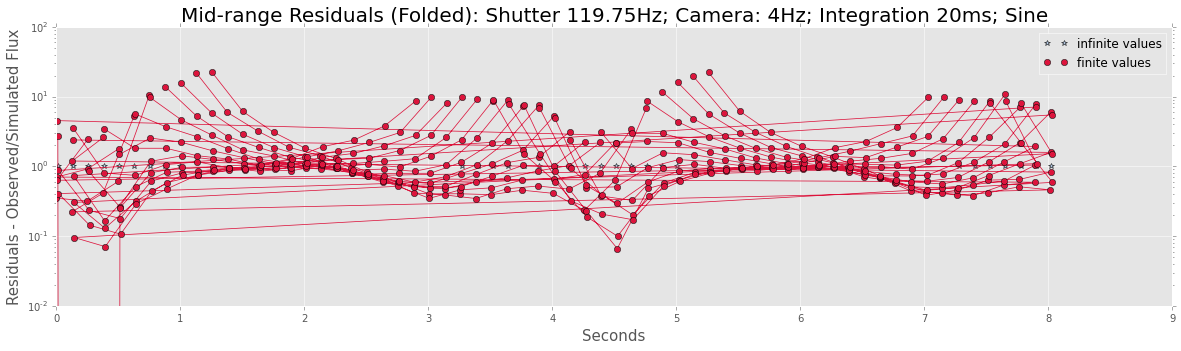

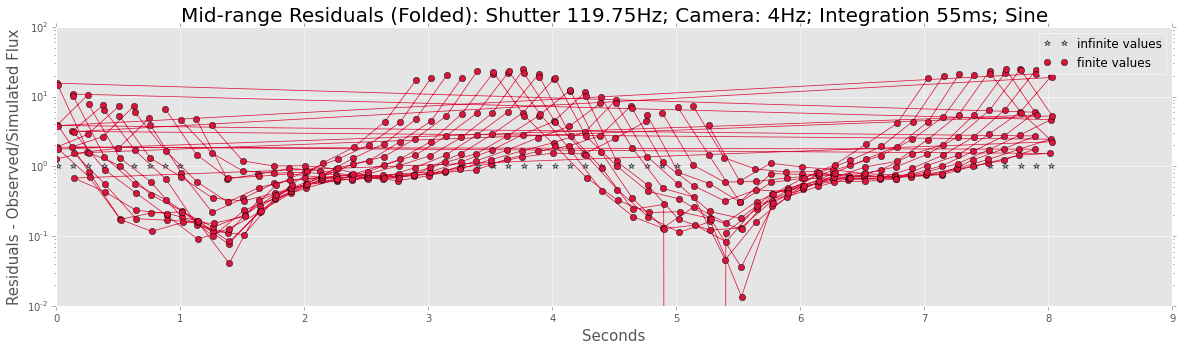

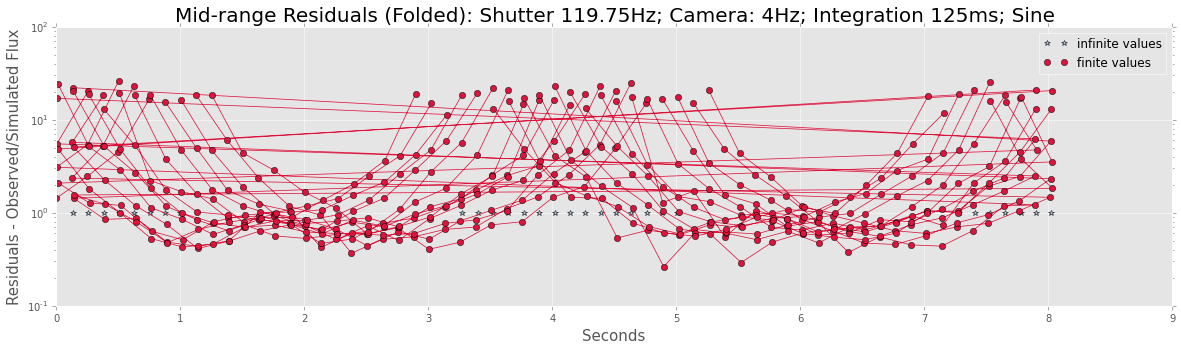

In [22]:
folded_mid_res = {}

for key, value in folded_mid.iteritems():
    # to be consistent with the 500 points on the flux wave
    # sample the points on the sine wave over each 250ms interval
    folded_mid_res[key] = value['flux']/inter_sn[np.arange(125000)%250==0]
    
    pl.figure(figsize=(20,5))
    
    inf_idx = np.where(folded_mid_res[key]==inf)[0]
    pl.plot(value['time'][inf_idx], np.ones(len(inf_idx)), '*', c='lightsteelblue', label='infinite values')
    
    pl.plot(value['time'], folded_mid_res[key], '-', c='crimson', lw=0.75)
    pl.plot(value['time'], folded_mid_res[key], 'o', c='crimson', label='finite values')
    pl.xlabel("Seconds", fontsize=15)
    pl.ylabel("Residuals - Observed/Simulated Flux", fontsize=15)
    pl.title('Mid-range Residuals (Folded): Shutter 119.75Hz; Camera: 4Hz; Integration '+str(key)+'ms; Sine', fontsize=20)
    if inf_idx.size:
        pl.legend(loc='best')
    pl.yscale('log')
    pl.show()